### module import

In [1]:
import os
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import LineString
import shapely.geometry as geom
import datetime as dt
import math
import csv
import json

### data import

In [34]:
#Importing Data
datadir = os.path.join(os.path.abspath(''),'data')

#REMOVE nrows arg for FULL DATASET , nrows=10000
#######################################################################################################
full_data = pd.read_csv(os.path.join(datadir, 'REISENDE.csv'), encoding = "utf-8", sep=';')
#######################################################################################################
haltep = pd.read_csv(os.path.join(datadir, 'haltepunkt.csv'))
haltest = pd.read_csv(os.path.join(datadir, 'HALTESTELLEN.csv'),encoding = "utf-8", sep=';')
haltest_link = pd.read_csv(os.path.join(datadir, 'haltestelle.csv'),encoding = "utf-8")
capacities = pd.read_csv(os.path.join(datadir, 'capacities.csv'), sep=';')

### intersect stops list with coordinate data to get geocoded list of stops

In [35]:
haltepunkte = haltep.copy()
haltestellen_link = haltest_link.copy()
haltestellen = haltest.copy()

#GPS from 'haltepunkte' (VBZ-Fahrzeiten-Daten) merged to VBZ 'haltestelle' (VBZ-Fahrzeiten-Daten) by halt_id, then haltestelle is merged to 'haltestellen' (VBZ-Passagierzahl-Daten)  by haltestellenkurzname

haltepunkte = haltepunkte[haltepunkte['halt_punkt_ist_aktiv'] == True]
haltepunkte = haltepunkte.drop(columns=['halt_punkt_ist_aktiv','GPS_Bearing','halt_punkt_id','halt_punkt_diva'])
haltepunkte = haltepunkte.groupby(['halt_id']).mean()[['GPS_Latitude','GPS_Longitude']].reset_index()

#Delete unneeded columns from haltestellen
haltestellen_link = haltestellen_link.drop(columns=['halt_diva', 'halt_ist_aktiv', 'halt_lang'])
haltestellen = haltestellen.drop(columns=['Haltestellennummer'])

halttemp = haltestellen_link.merge(haltepunkte, on='halt_id')

stops = halttemp.merge(haltestellen, left_on='halt_kurz', right_on='Haltestellenkurzname')
stops = stops.drop(columns=['halt_kurz', 'halt_id', 'Haltestellenkurzname'])

### export stops as geojson if needed

In [4]:
out_stops=stops.copy()

#shorten attribute
out_stops=out_stops.rename(columns={
    "Haltestellenlangname" : "name"})

#convert to geodatabase
stopsgdf=gpd.GeoDataFrame(
    out_stops, geometry=gpd.points_from_xy(out_stops.GPS_Longitude, out_stops.GPS_Latitude))
#cleanup
stopsgdf = stopsgdf.drop(columns=["GPS_Latitude", "GPS_Longitude", "Haltestellen_Id"])

#function to build json file
def df_to_geojson(out_stops, properties, lat='latitude', lon='longitude'):
    geojson = {'type':'FeatureCollection', 'features':[]}
    for _, row in out_stops.iterrows():
        feature = {'type':'Feature',
                   'properties':{},
                   'geometry':{'type':'Point',
                               'coordinates':[]}}
        feature['geometry']['coordinates'] = [row['GPS_Longitude'],row['GPS_Latitude']]
        
        for prop in properties:
            feature['properties'][prop] = row[prop]
        geojson['features'].append(feature)
    return geojson

#define attributes to be included in geojson file
col = ['name']

#output
geojson = df_to_geojson(out_stops, col)
output_filename = r"C:\Users\bountan\Drive\UZH\Ω_Archive\RVP GIS Student Award\weiterentwicklung_homepage\vbz-flow-website\data\haltestellen_onlyupdate.geojson"
with open(output_filename, 'w', encoding='utf-8') as output_file:
    json.dump(geojson, output_file, separators=(", ", ": "), ensure_ascii=False)

### calculate statistical values from data, adjust datetime format and weekday types

In [49]:
#Merge capacity data
mergedata=full_data.copy()
data = mergedata.merge(capacities, left_on = 'Linienname', right_on = 'Linienname')

#Calculate Capacity values
data['Auslastung'] = data['Besetzung'] / data['Capacity']
data['Freiplatz'] = data['Capacity'] - data['Besetzung']

#Delete connections made by cablecars and night liners
data = data[(data.VSYS == 'B') | (data.VSYS == 'TR') | (data.VSYS == 'T') | (data.VSYS == 'N')]

# Time to hour int



#data.FZ_AB = pd.to_datetime(data.FZ_AB)
 
data.FZ_AB = data.FZ_AB.str.replace('^24:','00:').str.replace('^25:','01:')  
data.FZ_AB = data.FZ_AB.str.slice(stop=2).astype(int)


#Delete end and start segments by filtering for NaN-values
data = data[(data.Haltestellen_Id == data.Haltestellen_Id) & (data.Nach_Hst_Id == data.Nach_Hst_Id)]

#Stop ID was float, should be int
data['Nach_Hst_Id'] = data['Nach_Hst_Id'].astype('int')

#create weekday-weekend attribute: weekday = 1, weekend = 0
def assigndaytype(row):
    if row['Tage_SA'] == 0:
        if row['Tage_SO'] == 0:
            if row['Tage_SA_N'] == 0:
                if row['Tage_SO_N'] == 0:
                    if row['Nachtnetz'] == 0:
                        val=1
                    else:
                        val=0
                else:
                        val=0
            else:
                        val=0
        else:
                        val=0
    else:
                        val=0
    return val
        

data['daytype'] = data.apply(assigndaytype, axis=1)

#data = data.drop(columns=['Einsteiger', 'Aussteiger', 'Tagtyp_Id', 'Linien_Id','Tage_DTV', 'Tage_DWV', 'Tage_SA', 'Tage_SO', 'Tage_SA_N', 'Tage_SO_N', 'Nachtnetz', 'Tage_SA'])
display(data)

#Select only weekdays, delete unneeded columns
#data = data[(data.Tage_SA == 0) & (data.Tage_SO == 0) & (data.Tage_SO_N == 0) & (data.Tage_SA_N == 0) & (data.Nachtnetz == 0)]
#data = data.drop(columns=['Einsteiger', 'Aussteiger', 'Tagtyp_Id', 'Linien_Id','Tage_DTV', 'Tage_DWV', 'Tage_SA', 'Tage_SO', 'Tage_SA_N', 'Tage_SO_N', 'Nachtnetz', 'Tage_SA'])

,Tagtyp_Id,Linien_Id,Linienname,Plan_Fahrt_Id,Richtung,Sequenz,Haltestellen_Id,Nach_Hst_Id,FZ_AB,Anzahl_Messungen,...,Tage_SO,Nachtnetz,Tage_SA_N,Tage_SO_N,ID_Abschnitt,VSYS,Capacity,Auslastung,Freiplatz,daytype
0,15,60,704,91534,2,1,576,575,5,11,...,0.0,0,0,0,57600575,B,82.71,0.055979,78.08,1
1,15,60,704,91534,2,2,575,574,5,11,...,0.0,0,0,0,57500574,B,82.71,0.055979,78.08,1
2,15,60,704,91534,2,3,574,451,5,11,...,0.0,0,0,0,57400451,B,82.71,0.037359,79.62,1
3,15,60,704,91534,2,4,451,511,5,11,...,0.0,0,0,0,45100511,B,82.71,0.041712,79.26,1
4,15,60,704,91534,2,5,511,512,5,11,...,0.0,0,0,0,51100512,B,82.71,0.042800,79.17,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910774,19,108,412,104722,1,18,364,365,1,0,...,13.0,0,0,0,36400365,TR,138.50,0.000000,138.50,0
910775,19,108,412,104722,1,19,365,168,1,0,...,13.0,0,0,0,36500168,TR,138.50,0.000000,138.50,0
910776,19,108,412,104722,1,20,168,366,1,0,...,13.0,0,0,0,16800366,TR,138.50,0.000000,138.50,0
910778,22,109,45,102681,1,1,273,683,15,31,...,0.0,0,0,0,27300683,B,82.71,0.290896,58.65,1


### merge stop list to edge list: make attributes from start and end stop lat and long

In [50]:
#Merge station names to segment start and end stops
topic_data = data.merge(stops, left_on = 'Haltestellen_Id', right_on = 'Haltestellen_Id')
topic_data = topic_data.merge(stops, left_on = 'Nach_Hst_Id', right_on = 'Haltestellen_Id', suffixes=('_start','_ziel'))
topic_data = topic_data.drop(columns=['Nach_Hst_Id'])             

topic_data = topic_data.rename(columns = {
                                  "Haltestellenlangname_start": "name_start", 
                                  "Haltestellenlangname_ziel":"name_ziel", 
                                  "GPS_Latitude_start": "lat_start",
                                  "GPS_Latitude_ziel": "lat_ziel", 
                                  "GPS_Longitude_start":"long_start", 
                                  "GPS_Longitude_ziel": "long_ziel",
                                  "Haltestellen_Id_ziel": "id_ziel", 
                                  "Haltestellen_Id_start":"id_start", 
                                  "Linienname": "nr", 
                                  "FZ_AB": "time", 
                                  "ID_Abschnitt": "id_abschnitt"})



### nan values

### group edges by section, line and hour

In [51]:
#edges = pd.read_csv(os.path.join(os.path.abspath(''),'data', 'topic_data.csv'))
edges = topic_data.copy()

#Alternative grouping into smaller bins. here we just take the hour value for time bins of 1hr
#Group, calculate statistics and keep desired values (by selecting "first" as operation)

#Attention: select time bins: 
#If hourly groups desired, first apply 
#  edges['time']=edges['time'].dt.hour

# otherwise use Grouper in place of a column name:
#  pd.Grouper(key='time', freq='10T', axis=0, sort=False)     --> stands for 10-Minute-Bins


#edges['time']=pd.to_datetime(edges['time'])
#edges['time']=edges['time'].dt.hour

########################################################################
######## line seperation or not decides here !!! 
######## , add 'nr' to "groupby" arg to seperate info by lines
########################################################################
edges = edges.groupby(['time', 'id_abschnitt', 'daytype']).agg(
                occsum=('Besetzung', 'sum'),
                occmean=('Besetzung', 'mean'),
                loadmax=('Auslastung', 'max'),
                loadmean=('Auslastung', 'mean'),
                name_start=('name_start', 'first'),
                lat_start=('lat_start', 'first'),
                long_start=('long_start', 'first'),
                name_ziel=('name_ziel', 'first'),
                lat_ziel=('lat_ziel', 'first'),
                long_ziel=('long_ziel', 'first')
)
#Round values appropriately (and awkwardly, to get rid of float artifacts)            
#edges['loadmax'] = edges['loadmax']*100
#edges['loadmax'] = edges['loadmax'].astype(int)


edges = edges[pd.notna(edges['loadmax']) == True]
edges = edges[pd.notna(edges['loadmean']) == True]
display(edges)


edges['loadmean'] = edges['loadmean']*100
edges['loadmean'] = edges['loadmean'].astype(int)

edges['occsum'] = edges['occsum'].astype(int)
edges['occmean'] = edges['occmean'].astype(int)

#Reset index to run number 
edges['i'] = np.arange(len(edges))
edges = edges.reset_index()
edges.set_index('i')
edges=edges.drop(columns=['i'])

#Remove all lines, where start and ziel are identical
#NOT IDEAL ! FIND ERRORS TO BEGIN WITH
edges = edges.query("lat_start != lat_ziel and long_start != long_ziel")


display(edges)

occsum    occmean   loadmax  loadmean  \
time id_abschnitt daytype                                          
0    400005       0         57.27  19.090000  0.333212  0.230806   
                  1         30.10  15.050000  0.185830  0.181961   
     400020       0         11.74   5.870000  0.120058  0.070971   
                  1          3.59   3.590000  0.043405  0.043405   
     400220       0         64.54   1.744324  0.036237  0.012861   
...                           ...        ...       ...       ...   
23   69100692     1          4.36   2.180000  0.032402  0.026357   
     69200693     0          5.16   1.290000  0.028171  0.015597   
                  1          3.28   1.640000  0.025994  0.019828   
     69300691     0         14.00   3.500000  0.157176  0.042317   
                  1          2.23   1.115000  0.013783  0.013481   

                                              name_start  lat_start  \
time id_abschnitt daytype                                             
0    400005       0        Zürich, Bahnhof Tiefenbrunnen  47.349974   
                  1        Zürich, Bahnhof Tiefenbrunnen  47.349974   
     400020       0        Zürich, Bahnhof Tiefenbrunnen  47.349974   
                  1        Zürich, Bahnhof Tiefenbrunnen  47.349974   
     400220       0        Zürich, Bahnhof Tiefenbrunnen  47.349974   
...                                                  ...        ...   
23   69100692     1         Küsnacht ZH, Hesligenstrasse  47.315608   
     69200693     0            Küsnacht ZH, Ränkestrasse  47.314470   
                  1            Küsnacht ZH, Ränkestrasse  47.314470   
     69300691     0                 Küsnacht ZH, Allmend  47.315848   
                  1                 Küsnacht ZH, Allmend  47.315848   

                           long_start                     name_ziel  \
time id_abschnitt daytype                                             
0    400005       0          8.561296        Zollikon, Bahnübergang   
                  1          8.561296        Zollikon, Bahnübergang   
     400020       0          8.561296           Zürich, Chinagarten   
                  1          8.561296           Zürich, Chinagarten   
     400220       0          8.561296       Zürich, Wildbachstrasse   
...                               ...                           ...   
23   69100692     1          8.593357     Küsnacht ZH, Ränkestrasse   
     69200693     0          8.595617          Küsnacht ZH, Allmend   
                  1          8.595617          Küsnacht ZH, Allmend   
     69300691     0          8.597198  Küsnacht ZH, Hesligenstrasse   
                  1          8.597198  Küsnacht ZH, Hesligenstrasse   

                            lat_ziel  long_ziel  
time id_abschnitt daytype                        
0    400005       0        47.345915   8.565867  
                  1        47.345915   8.565867  
     400020       0        47.355212   8.552421  
                  1        47.355212   8.552421  
     400220       0        47.353212   8.558830  
...                              ...        ...  
23   69100692     1        47.314470   8.595617  
     69200693     0        47.315848   8.597198  
                  1        47.315848   8.597198  
     69300691     0        47.315608   8.593357  
                  1        47.315608   8.593357  

[55575 rows x 10 columns]

,time,id_abschnitt,daytype,occsum,occmean,loadmax,loadmean,name_start,lat_start,long_start,name_ziel,lat_ziel,long_ziel
0,0,400005,0,57,19,0.333212,23,"Zürich, Bahnhof Tiefenbrunnen",47.349974,8.561296,"Zollikon, Bahnübergang",47.345915,8.565867
1,0,400005,1,30,15,0.185830,18,"Zürich, Bahnhof Tiefenbrunnen",47.349974,8.561296,"Zollikon, Bahnübergang",47.345915,8.565867
2,0,400020,0,11,5,0.120058,7,"Zürich, Bahnhof Tiefenbrunnen",47.349974,8.561296,"Zürich, Chinagarten",47.355212,8.552421
3,0,400020,1,3,3,0.043405,4,"Zürich, Bahnhof Tiefenbrunnen",47.349974,8.561296,"Zürich, Chinagarten",47.355212,8.552421
4,0,400220,0,64,1,0.036237,1,"Zürich, Bahnhof Tiefenbrunnen",47.349974,8.561296,"Zürich, Wildbachstrasse",47.353212,8.558830
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55570,23,69100692,1,4,2,0.032402,2,"Küsnacht ZH, Hesligenstrasse",47.315608,8.593357,"Küsnacht ZH, Ränkestrasse",47.314470,8.595617
55571,23,69200693,0,5,1,0.028171,1,"Küsnacht ZH, Ränkestrasse",47.314470,8.595617,"Küsnacht ZH, Allmend",47.315848,8.597198
55572,23,69200693,1,3,1,0.025994,1,"Küsnacht ZH, Ränkestrasse",47.314470,8.595617,"Küsnacht ZH, Allmend",47.315848,8.597198
55573,23,69300691,0,14,3,0.157176,4,"Küsnacht ZH, Allmend",47.315848,8.597198,"Küsnacht ZH, Hesligenstrasse",47.315608,8.593357


### Shorten vectors for visual purpose and export to GeoJSON

In [52]:
sections_with_coord = edges.copy()

#shift parameters
###########################################################################
length_param = 0.0009 #shorten vector to make more readable
###########################################################################

for index,row in sections_with_coord.iterrows():
    
    dlong = row[-1]-row[-4]
    dlat = row[-2]-row[-5]
    
    #section of traffic flow
    vector = (dlat, dlong)
    
    #scalar length of vector
    length = math.sqrt(dlat**2 + dlong**2)
    
    #normalvector = (-dlong, dlat)
    
    unitvector = (dlat/length,dlong/length)

    #unitnormalvector = (normalvector[0]/length,normalvector[1]/length)
    
    sections_with_coord.loc[index, 'lat_start'] = row[-5] + (length_param * unitvector[0])
    sections_with_coord.loc[index, 'long_start'] = row[-4] + (length_param * unitvector[1])
    sections_with_coord.loc[index, 'lat_ziel'] = row[-2] - (length_param * unitvector[0])
    sections_with_coord.loc[index, 'long_ziel'] = row[-1] - (length_param * unitvector[1])

display(sections_with_coord)

##################################################
### Output to (one) JSON File
##################################################

#define function to manually output geojson file (slimmer than geopandas creates its files!)
proctable=sections_with_coord.copy()
def df_to_geojson(proctable, properties, lat='latitude', lon='longitude'):
    geojson = {'type':'FeatureCollection', 'features':[]}
    for _, row in proctable.iterrows():
        feature = {'type':'Feature',
                   'properties':{},
                   'geometry':{'type':'LineString',
                               'coordinates':[[]]}}
        feature['geometry']['coordinates'] = [[row['long_start'],row['lat_start']], [row['long_ziel'],row['lat_ziel']]]
        for prop in properties:
            feature['properties'][prop] = row[prop]
        geojson['features'].append(feature)
    return geojson

#define attributes to be included in geojson file
col = ['time', 'daytype', 'occsum', 'occmean', 'loadmax', 'loadmean', 'name_start', 'name_ziel'] 
    
#output
geojson = df_to_geojson(proctable, col)
#output_filename = "vbz.geojson"
output_filename= r"C:\Users\bountan\Drive\UZH\Ω_Archive\RVP GIS Student Award\weiterentwicklung_homepage\vbz-website\vbz-flow-concept\data\vbz.geojson"
with open(output_filename, 'w', encoding='utf-8') as output_file:
    json.dump(geojson, output_file, separators=(", ", ": "), ensure_ascii=False) 


,time,id_abschnitt,daytype,occsum,occmean,loadmax,loadmean,name_start,lat_start,long_start,name_ziel,lat_ziel,long_ziel
0,0,400005,0,57,19,0.333212,23,"Zürich, Bahnhof Tiefenbrunnen",47.349377,8.561969,"Zollikon, Bahnübergang",47.346513,8.565194
1,0,400005,1,30,15,0.185830,18,"Zürich, Bahnhof Tiefenbrunnen",47.349377,8.561969,"Zollikon, Bahnübergang",47.346513,8.565194
2,0,400020,0,11,5,0.120058,7,"Zürich, Bahnhof Tiefenbrunnen",47.350432,8.560521,"Zürich, Chinagarten",47.354754,8.553196
3,0,400020,1,3,3,0.043405,4,"Zürich, Bahnhof Tiefenbrunnen",47.350432,8.560521,"Zürich, Chinagarten",47.354754,8.553196
4,0,400220,0,64,1,0.036237,1,"Zürich, Bahnhof Tiefenbrunnen",47.350690,8.560750,"Zürich, Wildbachstrasse",47.352496,8.559375
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55570,23,69100692,1,4,2,0.032402,2,"Küsnacht ZH, Hesligenstrasse",47.315203,8.594161,"Küsnacht ZH, Ränkestrasse",47.314875,8.594813
55571,23,69200693,0,5,1,0.028171,1,"Küsnacht ZH, Ränkestrasse",47.315061,8.596295,"Küsnacht ZH, Allmend",47.315257,8.596520
55572,23,69200693,1,3,1,0.025994,1,"Küsnacht ZH, Ränkestrasse",47.315061,8.596295,"Küsnacht ZH, Allmend",47.315257,8.596520
55573,23,69300691,0,14,3,0.157176,4,"Küsnacht ZH, Allmend",47.315792,8.596300,"Küsnacht ZH, Hesligenstrasse",47.315664,8.594255


### Statistical viewing

count    55480.000000
mean       323.222657
std        515.767503
min          0.000000
20%         20.000000
40%         62.000000
50%        105.000000
60%        183.000000
80%        520.000000
max       7807.000000
Name: occsum, dtype: float64

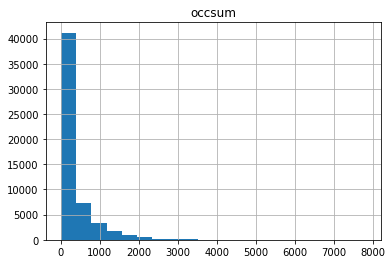

In [53]:
sections_with_coord.hist(column='occsum', bins=20)
pd.DataFrame.describe(sections_with_coord['occsum'], percentiles=[0.2,0.4,0.6,0.8])

### Output to (one) JSON File

In [201]:
#define function to manually output geojson file (slimmer than geopandas creates its files!)
proctable=sections_with_coord.copy()
def df_to_geojson(proctable, properties, lat='latitude', lon='longitude'):
    geojson = {'type':'FeatureCollection', 'features':[]}
    for _, row in proctable.iterrows():
        feature = {'type':'Feature',
                   'properties':{},
                   'geometry':{'type':'LineString',
                               'coordinates':[[]]}}
        feature['geometry']['coordinates'] = [[row['long_start'],row['lat_start']], [row['long_ziel'],row['lat_ziel']]]
        for prop in properties:
            feature['properties'][prop] = row[prop]
        geojson['features'].append(feature)
    return geojson

#define attributes to be included in geojson file
col = ['time', 'occsum', 'occmean', 'loadmax', 'loadmean', 'name_start', 'name_ziel']



#output
geojson = df_to_geojson(proctable, col)
output_filename = 'vbz.geojson'
with open(output_filename, 'w') as output_file:
    json.dump(geojson, output_file, separators=(", ", ": "), ensure_ascii=False) 

#### FOR TEST output data to excel

In [8]:
sections_with_GPS.to_excel("all.xlsx")  

#### OPTIONAL Plot data

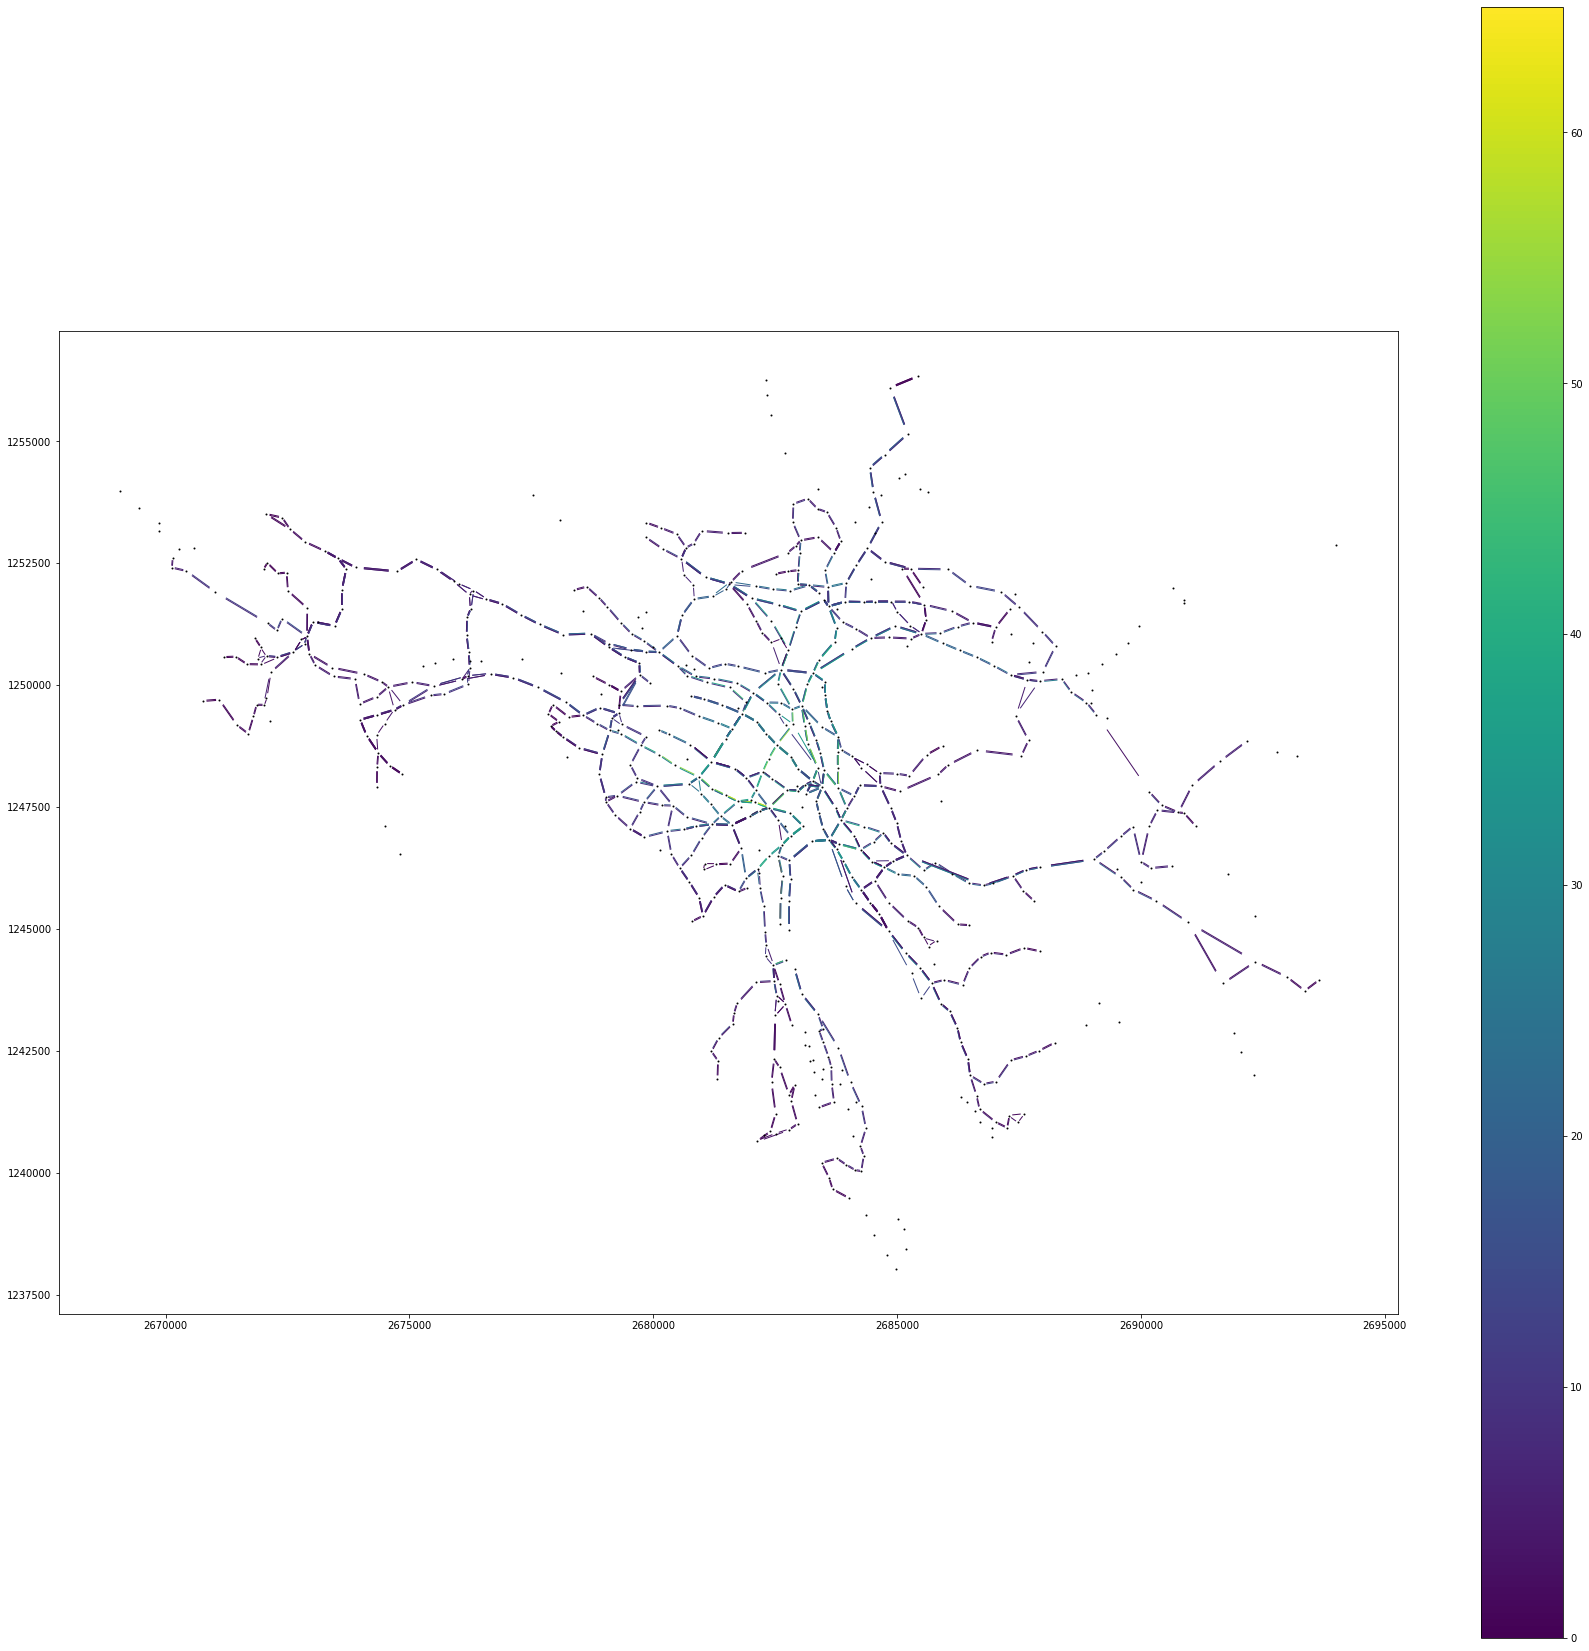

In [151]:
#Input list of desired hours and lines. Leave empty to include all.

#################################################################
plothours = [22]
plotlines = []
#################################################################


#Get selection from dataset
if plothours == []:
    if plotlines == []:
        plotdata = sections_with_GPS.copy()
    else: 
        plotdata = sections_with_GPS[sections_with_GPS['Linienname'].isin(plotlines)]
elif plotlines == []:         
        plotdata = sections_with_GPS[sections_with_GPS['time'].isin(plothours)]
else:
    plotdata = sections_with_GPS[(sections_with_GPS['time'].isin(plothours)) & (sections_with_GPS['Linienname'].isin(plotlines))]



#Reproject Stadtkreise
citymap.crs = {'init' :'epsg:4326'}
citymap=citymap.to_crs(epsg=2056)

fig, ax = plt.subplots(1, figsize=(30,30))
base = citymap.plot(ax=ax, color = "0.9")

#Plot Edges
geodf = gpd.GeoDataFrame(plotdata, geometry=plotdata['edge'])
#Reproject Data
geodf.crs = {'init' :'epsg:4326'}
geodf=geodf.to_crs(epsg=2056)
geodf.plot(ax=base, column='Besetzung_Mean', legend=True, linewidth=1, zorder=1)

#Plot Stops
stopsgeodf = gpd.GeoDataFrame(stops, geometry= gpd.points_from_xy(stops.GPS_Longitude, stops.GPS_Latitude))
#Reproject Stops
stopsgeodf.crs = {'init' :'epsg:4326'}
stopsgeodf=stopsgeodf.to_crs(epsg=2056)

stopsgeodf.plot(ax=base, markersize=1, color='black', marker='o', zorder=2)

#Show and save plot to file
plt.show()
fig.savefig('vbz-out.png', dpi=600)

In [ ]:
sections_with_GPS = edges.copy()

#Create base geometry from latlong
sections_with_GPS['origin']=gpd.points_from_xy(sections_with_GPS.long_start, sections_with_GPS.lat_start)
sections_with_GPS['destiny']=gpd.points_from_xy(sections_with_GPS.long_ziel, sections_with_GPS.lat_ziel)
sections_with_GPS['edge']=[LineString(xy) for xy in zip(sections_with_GPS.origin, sections_with_GPS.destiny)]
sections_with_GPS=sections_with_GPS.drop(columns=['origin', 'destiny'])

#Set parameters for shift
########################################################################
shift_para = 0.0001 #Shift to right: smaller number eq smaller shift
length_para = 0.2 #remove x each end (if 0.1: 10% is removed each end)
########################################################################

#recalc edges shifted to right
linestrings = []
for index,row in sections_with_GPS.iterrows():
    dlong = row[-2]-row[-5]
    dlat = row[-3]-row[-6]
    newvector = (dlong,-dlat)
    
    amount = math.sqrt(newvector[0]**2+newvector[1]**2)
    
    if norm != 0:
        newvectornorm = (newvector[0]/norm, newvector[1]/norm)
    else:
        newvectornorm = newvector
    newvectorpara = (newvectornorm[0]*shift_para,newvectornorm[1]*shift_para)
    linestrings.append(geom.LineString([(row[-5]+newvectorpara[0]+length_para*dx,row[-6]+newvectorpara[1]+length_para*dy),(row[-2]+newvectorpara[0]-length_para*dx,row[-3]+newvectorpara[1]-length_para*dy)]))
sections_with_GPS['edge']=pd.Series(data=linestrings,index=sections_with_GPS.index)
sections_with_GPS['id_abschnitt'] = sections_with_GPS.index
